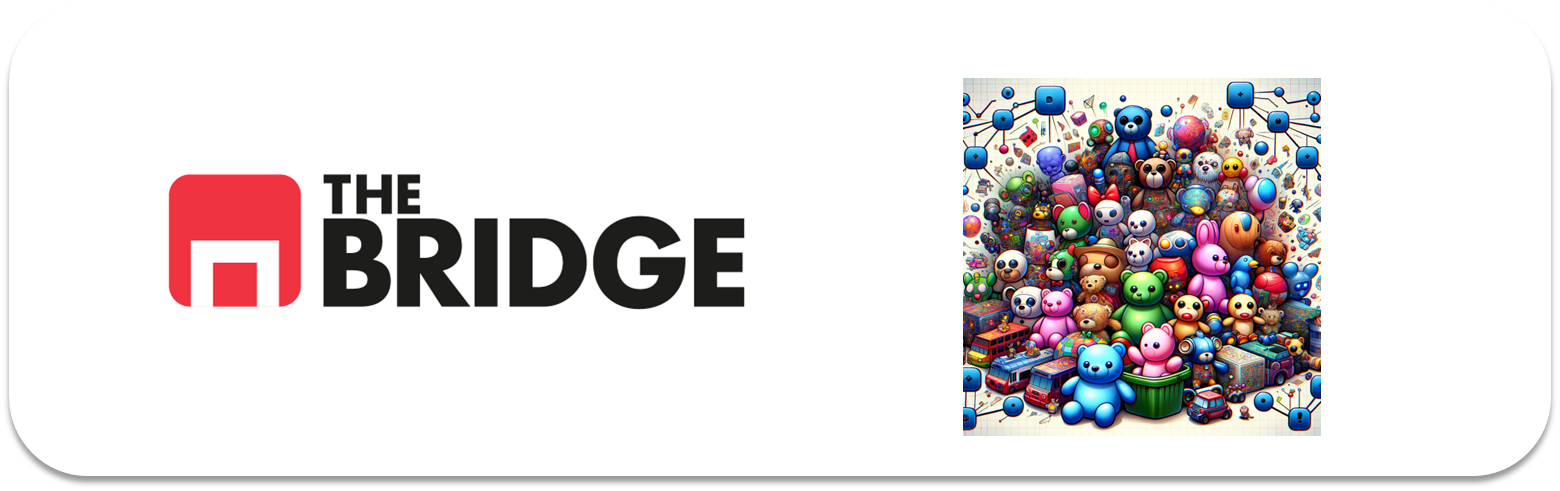

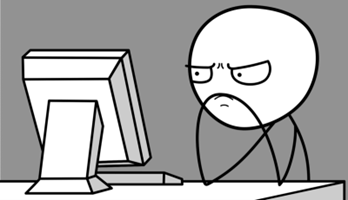

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [2]:
# Ejercicio 0: Importar paquetes y módulos necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [3]:

# Configuración de los gráficos
sns.set(style="whitegrid")


### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [5]:

# Ejercicio 1: Importar los datos y realizar una inspección preliminar
# Cargar el dataset
data = pd.read_csv("./data/drugLibTrain_raw.tsv", sep='\t')

# Inspección preliminar
data.head()



,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [6]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


In [7]:
data.describe()

,Unnamed: 0,rating
count,3107.000000,3107.000000
mean,2080.607016,7.006115
std,1187.998828,2.937582
min,0.000000,1.000000
25%,1062.500000,5.000000
50%,2092.000000,8.000000
75%,3092.500000,9.000000
max,4161.000000,10.000000


In [16]:

# Eliminar columnas innecesarias
# Supongamos que 'url' es la columna que queremos eliminar
data = data.drop(columns=['Unnamed:'], errors='ignore')


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [17]:

# Ejercicio 2: MiniEDA - Análisis de cardinalidad
cardinality = data.nunique() / len(data) * 100
cardinality_df = pd.DataFrame({
    'Feature': data.columns,
    'Cardinality (%)': cardinality
})

# Mostrar características con su cardinalidad
print(cardinality_df)

# Seleccionar features a conservar (usualmente, se pueden descartar con cardinalidad alta)
# Por ejemplo, descartamos columnas con cardinalidad > 80%
features_to_keep = cardinality_df[cardinality_df['Cardinality (%)'] <= 80]['Feature'].tolist()
data_filtered = data[features_to_keep]


                             Feature  Cardinality (%)
Unnamed: 0                Unnamed: 0       100.000000
urlDrugName              urlDrugName        16.157065
rating                        rating         0.321854
effectiveness          effectiveness         0.160927
sideEffects              sideEffects         0.160927
condition                  condition        45.896363
benefitsReview        benefitsReview        97.553911
sideEffectsReview  sideEffectsReview        90.537496
commentsReview        commentsReview        98.036691


### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [18]:

# Ejercicio 3: Construcción del train set (X)
X = data_filtered.copy()


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [19]:

# Ejercicio 4: Transformación de features y escalado
# Identificar columnas categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Crear un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Aplicar transformaciones
X_transformed = preprocessor.fit_transform(X)


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

In [20]:

# Ejercicio 5: Análisis visual de la relación entre features
# Convertir a DataFrame para visualización
X_df = pd.DataFrame(X_transformed)

# Scatter plot para las primeras dos features transformadas
plt.figure(figsize=(12, 6))
plt.scatter(X_df.iloc[:, 0], X_df.iloc[:, 1])
plt.title('Scatter plot de las primeras dos features transformadas')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


IndexError: single positional indexer is out-of-bounds

<Figure size 1200x600 with 0 Axes>

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

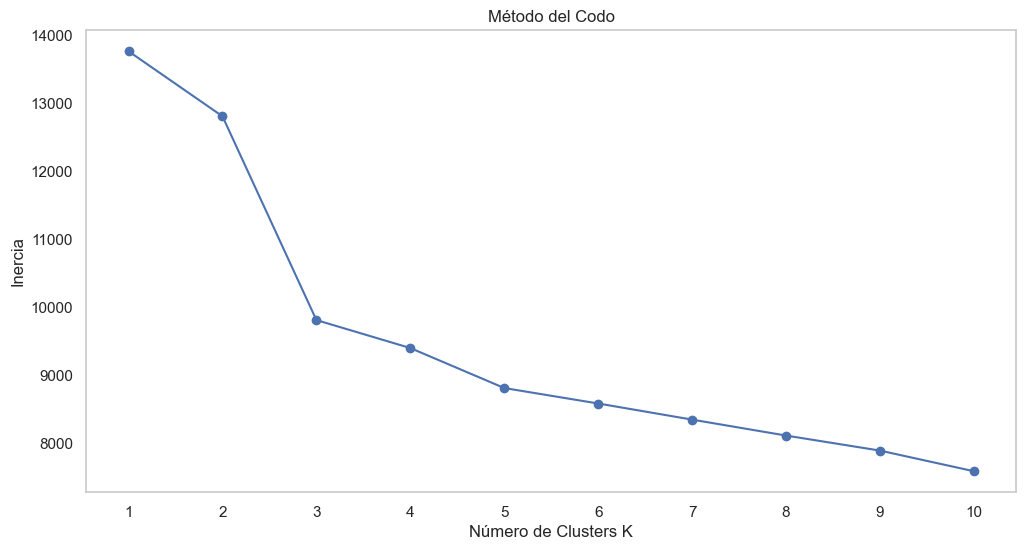

In [21]:

# Ejercicio 6: Método del codo para determinar K
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(12, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters K')
plt.ylabel('Inercia')
plt.xticks(K_range)
plt.grid()
plt.show()


### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

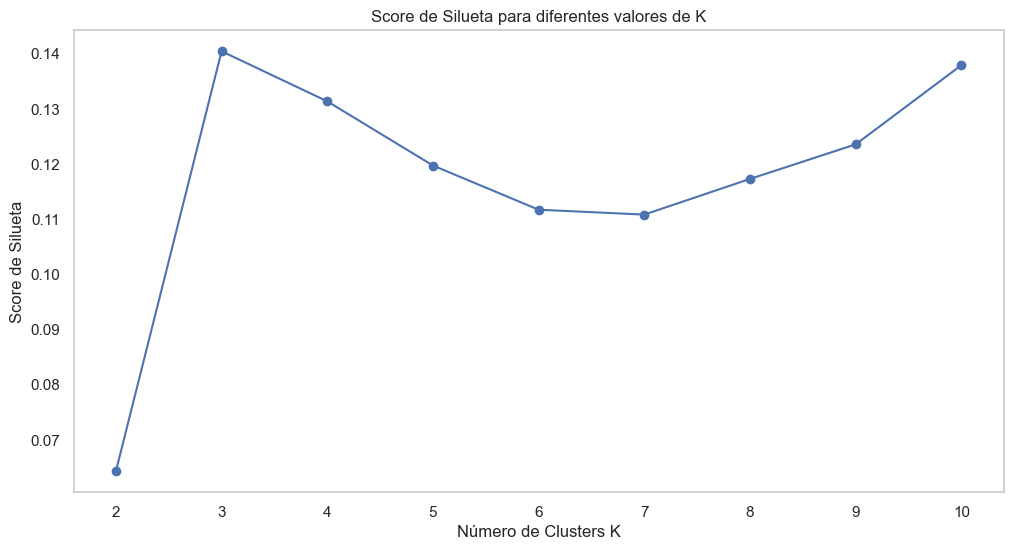

In [22]:

# Ejercicio 7: Score de Silueta
silhouette_scores = []

for k in K_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_transformed)
    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el score de silueta
plt.figure(figsize=(12, 6))
plt.plot(K_range[1:], silhouette_scores, marker='o')
plt.title('Score de Silueta para diferentes valores de K')
plt.xlabel('Número de Clusters K')
plt.ylabel('Score de Silueta')
plt.xticks(K_range[1:])
plt.grid()
plt.show()


### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

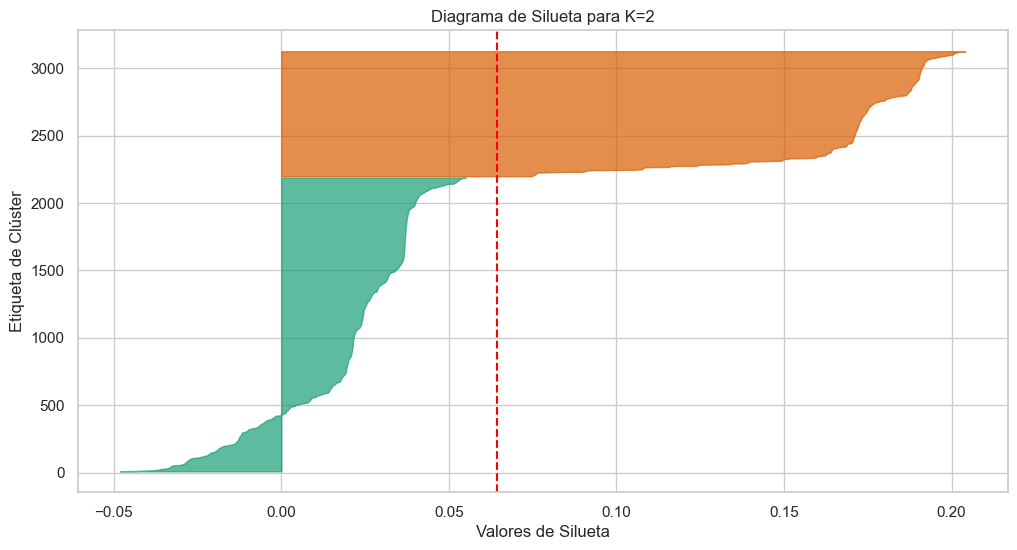

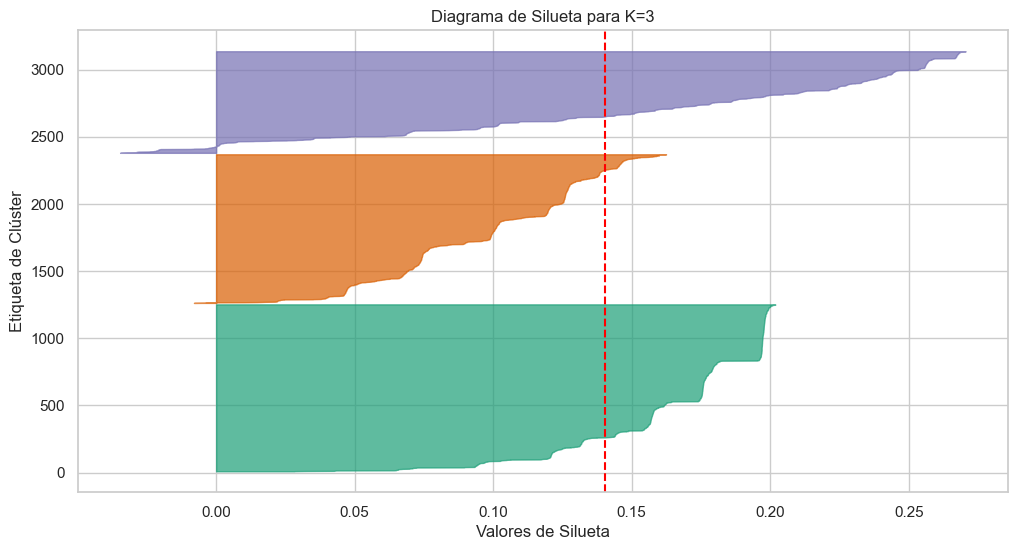

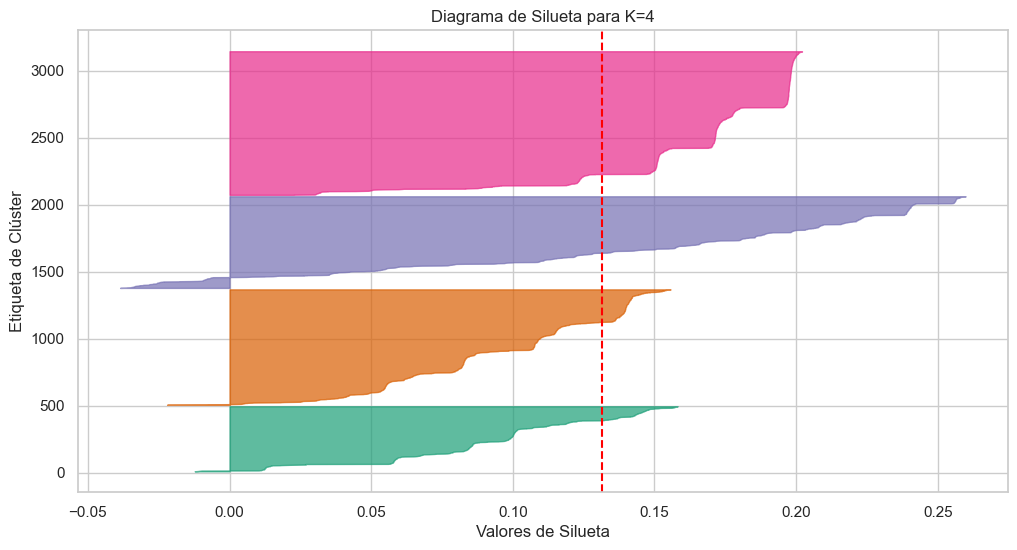

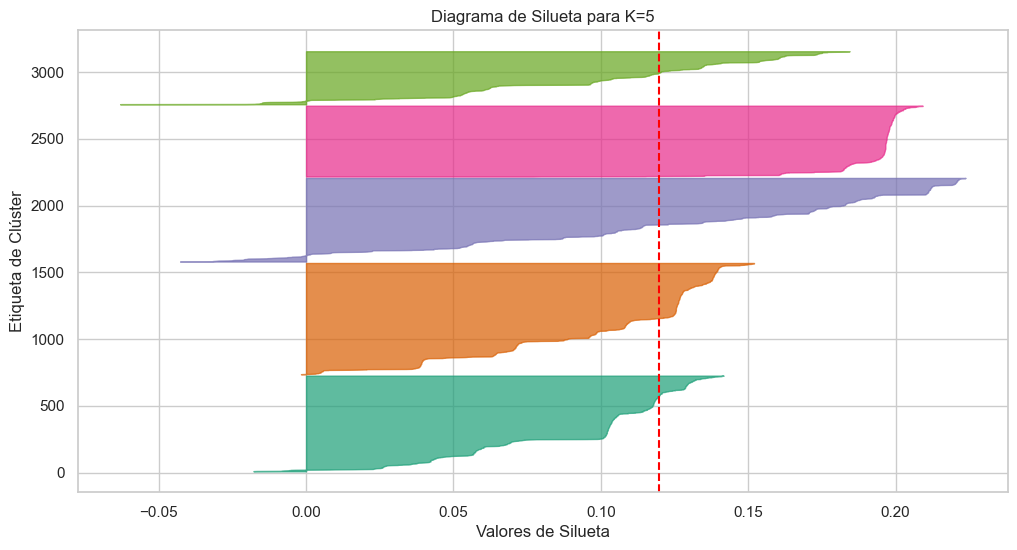

In [23]:

# Ejercicio 8: Diagrama de silueta
from sklearn.metrics import silhouette_samples

for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_transformed)
    
    silhouette_vals = silhouette_samples(X_transformed, cluster_labels)
    y_lower = 10
    
    plt.figure(figsize=(12, 6))
    for i in range(k):
        # Para cada clúster, obtener el rango de puntos
        ith_cluster_silhouette_values = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Visualizar el rango de valores de silueta para este clúster
        size = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size
        
        color = sns.color_palette("Dark2")[i]
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)
        
        # Actualizar el límite inferior para el siguiente clúster
        y_lower = y_upper + 10  # Espacio entre clústeres
        
    plt.title(f'Diagrama de Silueta para K={k}')
    plt.xlabel('Valores de Silueta')
    plt.ylabel('Etiqueta de Clúster')
    plt.axvline(x=silhouette_scores[k-2], color="red", linestyle="--")
    plt.show()


### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [24]:

# Ejercicio 9: Construcción del modelo K-means para el K seleccionado
optimal_k = 3  # Cambiar según el análisis anterior
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_transformed)



### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

In [25]:

# Ejercicio 10: Análisis de resultados y visualización
cluster_analysis = X.groupby('Cluster').mean()
print(cluster_analysis)

# Visualización con pairplot
sns.pairplot(X, x_vars=['sideEffects'], y_vars=['rating'], hue='Cluster', palette='viridis')
plt.show()

TypeError: agg function failed [how->mean,dtype->object]

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

In [26]:

# Ejercicio 11: Análisis para un K diferente
alternative_k = 4  # Cambiar según el análisis anterior
kmeans_alt = KMeans(n_clusters=alternative_k, random_state=42)
X['Cluster_Alt'] = kmeans_alt.fit_predict(X_transformed)

# Análisis de resultados para el K alternativo
cluster_analysis_alt = X.groupby('Cluster_Alt').mean()
print(cluster_analysis_alt)

# Visualización para el K alternativo
sns.pairplot(X, x_vars=['sideEffects'], y_vars=['rating'], hue='Cluster_Alt', palette='viridis')
plt.show()

TypeError: agg function failed [how->mean,dtype->object]